In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
import librosa
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from sklearn.model_selection import KFold
from collections import defaultdict

In [3]:
# Configuration
config = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'num_epochs': 150,
    'hidden_dim': 256,
    'latent_dim': 16,
    'input_dim': 64,
    'num_classes': 10,
    'weight_decay': 1e-4,
    'sample_rate': 22050,
    'n_mels': 128,
    'n_fft': 2048,
    'hop_length': 1024,
    'duration': 30,
}

In [4]:
# Dataset class for DataLoader
class GTZANDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            sample = self.transform(sample)
        return sample, label



#CALM Classification Model



In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the 4 convolutional layers with pooling sizes from paper
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(4, 4))

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(4, 2))
        # Reduces frequency by 4 and time by 2 instead of 4
        # to reach 13 instead of 15 (possible error in paper)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #print("CNN Input shape: ", x.shape)
        # Apply convolution, activation, pooling, and dropout in each layer
        x = self.dropout(self.pool1(F.relu(self.conv1(x))))
        x = self.dropout(self.pool2(F.relu(self.conv2(x))))
        x = self.dropout(self.pool3(F.relu(self.conv3(x))))
        x = self.dropout(self.pool4(F.relu(self.conv4(x))))

        return x


class LSTMAutoencoder(nn.Module):
    def __init__(self):
        super(LSTMAutoencoder, self).__init__()
        # Encoder LSTM with units {256, 64, 16}
        self.encoder_lstm1 = nn.LSTM(64, 256, batch_first=True, dropout=0.5)
        self.encoder_lstm2 = nn.LSTM(256, 64, batch_first=True, dropout=0.5)
        self.encoder_lstm3 = nn.LSTM(64, 16, batch_first=True, dropout=0.5)

        # Decoder LSTM with units {16, 64, 256}
        self.decoder_lstm1 = nn.LSTM(16, 64, batch_first=True, dropout=0.5)
        self.decoder_lstm2 = nn.LSTM(64, 256, batch_first=True, dropout=0.5)
        self.decoder_lstm3 = nn.LSTM(256, 64, batch_first=True, dropout=0.5)

    def forward(self, x):
        #print("LSTM shape before encoding: ", x.shape)
        batch_size, time_steps, features = x.size()  # Input is [32, 1, 13]
        # Encode
        output, (h_n1, c_n1) = self.encoder_lstm1(x)
        output, (h_n2, c_n2) = self.encoder_lstm2(output)
        output, (h_n3, c_n3) = self.encoder_lstm3(output)


        # Decoder initialization with encoded state
        decoder_input = h_n3.expand(time_steps, batch_size, -1)  # Repeat across time steps for decoding
        decoder_output, _ = self.decoder_lstm1(decoder_input)
        decoder_output, _ = self.decoder_lstm2(decoder_output)
        decoder_output, _ = self.decoder_lstm3(decoder_output)

        # Interpolate to match original input dimensions
        decoder_output = decoder_output.permute(1, 0, 2) 
        decoder_output = decoder_output.view(batch_size, 1, 13, 64)  
        decoder_output = F.interpolate(decoder_output, size=(128, 647), mode='bilinear', align_corners=False)

        # Return reconstruction and encoded state
        return decoder_output, h_n3

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN()
        self.lstm_autoencoder = LSTMAutoencoder()

    def forward(self, x):
        cnn_output = self.cnn(x)
        lstm_input = cnn_output.view(x.size(0), 13, 64)  
        reconstruction, encoded_state = self.lstm_autoencoder(lstm_input)

        return reconstruction, encoded_state

# Input augmentation functions
def initialize_random_clusters(data, n_clusters=10):
    n_samples = data.size(0)
    initial_indices = torch.randperm(n_samples)[:n_clusters]
    cluster_centers = data[initial_indices]
    return cluster_centers

def assign_clusters(data, cluster_centers):
    distances = torch.cdist(data, cluster_centers)
    cluster_assignments = distances.argmin(dim=1)
    return cluster_assignments

def augment_data_with_clusters(batch_data, n_clusters=10):
    batch_size = batch_data.size(0)
    flattened_data = batch_data.view(batch_size, -1)
    cluster_centers = initialize_random_clusters(flattened_data, n_clusters=n_clusters)
    cluster_assignments = assign_clusters(flattened_data, cluster_centers)
    one_hot_clusters = F.one_hot(cluster_assignments, num_classes=n_clusters).float()
    augmented_batch = torch.cat([flattened_data, one_hot_clusters], dim=1)
    return augmented_batch, cluster_assignments, cluster_centers

# FNN model
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, feature_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.ln1 = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(32)
        self.leaky_relu = nn.LeakyReLU()
        self.feature_size = feature_size

    def forward(self, x):
        #print("FNN input shape: ", x.shape)
        x = self.leaky_relu(self.ln1(self.fc1(x)))
        x = self.leaky_relu(self.ln2(self.fc2(x)))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def calculate_dissimilarity(self, input_data, cluster_centers):
        # Use only the first 16 dimensions for input_data and cluster_centers
        input_data = input_data[:, :16]
        cluster_centers = cluster_centers[:, :16]

        n_samples, n_features = input_data.shape  
        n_clusters = cluster_centers.size(0)

        weight_matrix = self.fc1.weight[:, :16].abs().mean(dim=0)

        dissimilarity_matrix = torch.zeros(n_samples, n_clusters, device=input_data.device)
        for i in range(n_samples):
            for l in range(n_clusters):
                distance = (weight_matrix * torch.abs(input_data[i] - cluster_centers[l])).sum()
                dissimilarity_matrix[i, l] = distance

        return dissimilarity_matrix


# CALM Classifier integrating FNN and RandomForestClassifier
class CALMClassifier(nn.Module):
    def __init__(self, fnn_input_size, feature_size, n_clusters=10):
        super(CALMClassifier, self).__init__()
        self.fnn = FeedForwardNN(fnn_input_size, feature_size)
        self.random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
        self.n_clusters = n_clusters

    def forward(self, x):
        return self.fnn(x)

    def update_random_forest(self, data, cluster_labels):
        flattened_data = data.view(data.size(0), -1).cpu().numpy()
        self.random_forest.fit(flattened_data, cluster_labels.cpu().numpy())

    def predict_cluster_probabilities(self, data):
        flattened_data = data.view(data.size(0), -1).cpu().numpy()
        cluster_probs = self.random_forest.predict_proba(flattened_data)
        return torch.tensor(cluster_probs).to(data.device)

    def calculate_dissimilarity(self, input_data, cluster_centers):
        return self.fnn.calculate_dissimilarity(input_data, cluster_centers)



class FullCALMModel(nn.Module):
    def __init__(self, cnn_lstm, device, n_clusters=10):
        super(FullCALMModel, self).__init__()
        self.cnn_lstm = cnn_lstm
        self.calm_classifier = CALMClassifier(fnn_input_size=16 + n_clusters, feature_size=16 + n_clusters)
        self.n_clusters = n_clusters
        self.device = device

    def forward(self, x, cluster_labels):
        _, encoded_state = self.cnn_lstm(x)
        encoded_state = encoded_state.squeeze(0)
        standardized_data = (encoded_state - encoded_state.mean(dim=1, keepdim=True)) / \
                            (encoded_state.std(dim=1, keepdim=True) + 1e-8)
        one_hot_clusters = F.one_hot(cluster_labels, num_classes=self.n_clusters).float()
        augmented_data = torch.cat([standardized_data, one_hot_clusters.to(self.device)], dim=1)
        calm_output = self.calm_classifier(augmented_data)
        return calm_output, augmented_data

# Train CNN_LSTM
def trainCNN_LSTM(model, dataloader, device, num_epochs=20, learning_rate=0.001, weight_decay=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    model.train()
    losses = []
    total_samples = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, _ in dataloader:
            data = data.to(device)

            # Forward pass
            reconstruction, _ = model(data)

            # Calculate loss (RMSE between input and reconstruction)
            loss = torch.sqrt(criterion(reconstruction, data))
            epoch_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_samples += data.size(0)

        losses.append(epoch_loss/total_samples)

        # Print loss per epoch
        print(f'(CNN_LSTM) Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}')
    print("CNN_LSTM Training complete.")

def train_full_model(model, train_loader, optimizer, criterion, num_epochs, max_no_change_epochs=10):
    device = model.device
    model.train()

    # Step 1: Initialize cluster centers on CPU to save GPU memory
    all_encoded_states = []

    # Get all encoded states from the CNN_LSTM output
    with torch.no_grad():
        for batch_data, _ in train_loader:
            batch_data = batch_data.to(device)
            _, encoded_state = model.cnn_lstm(batch_data)
            all_encoded_states.append(encoded_state.squeeze(0).cpu()) 

    # Concatenate all encoded states for clustering
    all_encoded_states = torch.cat(all_encoded_states, dim=0)

    # Initialize clusters using the encoded states
    cluster_centers = initialize_random_clusters(all_encoded_states, n_clusters=model.n_clusters)
    cluster_assignments = assign_clusters(all_encoded_states, cluster_centers)

    no_change_count = 0
    
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Step 2: Training the FNN and clustering model
        for cluster_id in range(model.n_clusters):
            optimizer.zero_grad()

            # Select the data points belonging to the current cluster
            cluster_mask = (cluster_assignments == cluster_id)
            cluster_data = all_encoded_states[cluster_mask].to(device)
            cluster_labels = torch.full((cluster_data.size(0),), cluster_id, dtype=torch.long, device=device)

            # Cluster_data has shape [batch_size, feature_dim] for FullCALMModel processing
            if cluster_data.size(0) > 0:
                # Augment the data with one-hot encoded cluster labels
                one_hot_clusters = F.one_hot(cluster_labels, num_classes=model.n_clusters).float()
                augmented_data = torch.cat([cluster_data, one_hot_clusters.to(device)], dim=1)

                # Forward pass
                outputs = model.calm_classifier(augmented_data)
                loss = criterion(outputs, cluster_labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * cluster_data.size(0)
            else:
                print(f"Cluster {cluster_id} has no samples.")

            torch.cuda.empty_cache() 

        # Step 3: Update cluster centers and reassign clusters
        new_cluster_centers = []
        for cluster_id in range(model.n_clusters):
            cluster_data = all_encoded_states[cluster_assignments == cluster_id]
            if cluster_data.size(0) > 0:
                new_center = cluster_data.mean(dim=0)
            else:
                new_center = cluster_centers[cluster_id] 
            new_cluster_centers.append(new_center)
        new_cluster_centers = torch.stack(new_cluster_centers)

        # Calculate dissimilarity matrix and update cluster assignments
        dissimilarity_matrix = model.calm_classifier.calculate_dissimilarity(all_encoded_states[:, :16].to(device), new_cluster_centers[:, :16].to(device))
        new_cluster_assignments = dissimilarity_matrix.argmin(dim=1).cpu()

        # Check for consecutive unchanged cluster assignments
        if torch.equal(new_cluster_assignments, cluster_assignments):
            no_change_count += 1
            print(f"No change in cluster assignments for {no_change_count} consecutive epochs.")
            if no_change_count >= max_no_change_epochs:
                print(f"Stopping criterion met: No change in assignments for {max_no_change_epochs} consecutive epochs.")
                break
        else:
            no_change_count = 0  
        cluster_assignments = new_cluster_assignments  

        avg_loss = epoch_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)
        print(f"(FullCALMModel) Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        torch.cuda.empty_cache()  

    print("FullCALMModel Training complete.")
    return epoch_losses

(CNN_LSTM) Epoch [1/1], Loss: 0.3103147554397583
CNN_LSTM Training complete.
Training on reshuffled dataset...
(FullCALMModel) Epoch [1/150], Loss: 2.3149
(FullCALMModel) Epoch [2/150], Loss: 2.2963
(FullCALMModel) Epoch [3/150], Loss: 2.2812
(FullCALMModel) Epoch [4/150], Loss: 2.2563
(FullCALMModel) Epoch [5/150], Loss: 2.2101
(FullCALMModel) Epoch [6/150], Loss: 2.1652
(FullCALMModel) Epoch [7/150], Loss: 2.1172
(FullCALMModel) Epoch [8/150], Loss: 2.0582
(FullCALMModel) Epoch [9/150], Loss: 2.0141
(FullCALMModel) Epoch [10/150], Loss: 1.9765
(FullCALMModel) Epoch [11/150], Loss: 1.9406
(FullCALMModel) Epoch [12/150], Loss: 1.9074
(FullCALMModel) Epoch [13/150], Loss: 1.8754
(FullCALMModel) Epoch [14/150], Loss: 1.8461
(FullCALMModel) Epoch [15/150], Loss: 1.8190
(FullCALMModel) Epoch [16/150], Loss: 1.7943
(FullCALMModel) Epoch [17/150], Loss: 1.7717
(FullCALMModel) Epoch [18/150], Loss: 1.7492
(FullCALMModel) Epoch [19/150], Loss: 1.7273
(FullCALMModel) Epoch [20/150], Loss: 1.706

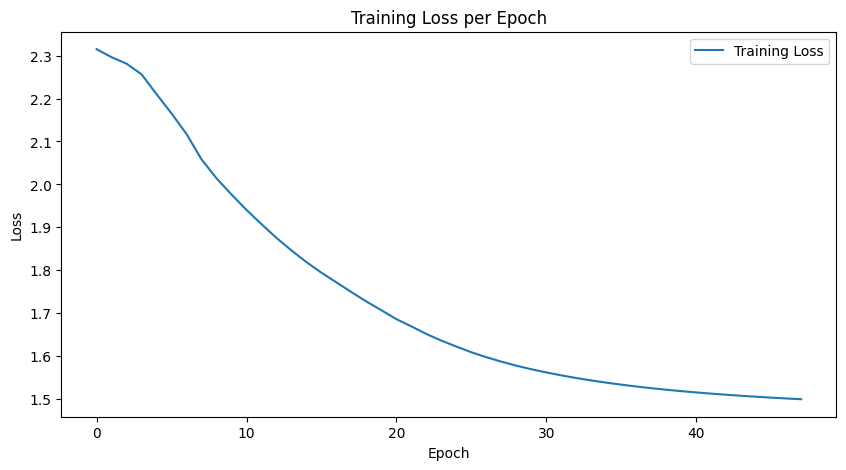

Validation Loss: 1.5146, Validation Accuracy: 100.00%
Test Loss: 1.5120, Test Accuracy: 100.00%


In [26]:
def evaluate_model(model, dataloader, criterion):
    model.cnn_lstm.eval()
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    batch_losses = []
    batch_accuracies = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(model.device), labels.to(model.device)

            # Get predictions and calculate loss
            outputs, _ = model(inputs, labels)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Predicted labels
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            batch_losses.append(loss.item())
            batch_accuracies.append(batch_accuracy)

            # Debugging information for each batch
            print(f"Batch {batch_idx + 1}: Loss = {loss.item():.4f}, Correct = {(predicted == labels).sum().item()}/{labels.size(0)}")

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = (correct_predictions / total_samples) * 100

    # Output results for validation
    print(f"Total Samples: {total_samples}, Total Correct: {correct_predictions}")
    print(f"Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy, batch_losses, batch_accuracies

# Function to shuffle, split, and evaluate with an 8:1:1 ratio
def shuffle_and_resplit_evaluate(model_class, combined_dataset, batch_size=32, num_epochs=150):
    total_size = len(combined_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Shuffle and split
    train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Split the training dataset into two halves
    train_size = len(train_loader.dataset) // 1
    remaining_size = len(train_loader.dataset) - train_size
    train_subset, _ = random_split(train_loader.dataset, [train_size, remaining_size])

    # Define a DataLoader for just the train subset
    train_subset_loader = DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True)

    # Train CNN_LSTM on the subset
    cnn_lstm_model = CNN_LSTM().to(device)
    trainCNN_LSTM(cnn_lstm_model, train_subset_loader, device, num_epochs=1) 

    # Freeze CNN_LSTM parameters after training on subset
    for param in cnn_lstm_model.parameters():
        param.requires_grad = False


    model = FullCALMModel(cnn_lstm_model, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    print("Training on reshuffled dataset...")
    epoch_losses = train_full_model(model, train_loader, optimizer, criterion, num_epochs=num_epochs)
    print("Training losses: ", epoch_losses)

    # Evaluate and collect data for plotting
    val_loss, val_accuracy, val_batch_losses, val_batch_accuracies = evaluate_model(model, val_loader, criterion)
    test_loss, test_accuracy, test_batch_losses, test_batch_accuracies = evaluate_model(model, test_loader, criterion)

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.legend()
    plt.savefig("training_loss.png")
    plt.show()

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Load and combine the original train and test datasets for reshuffling and splitting
train_data = torch.load('./Data/Dataset/train_dataset.pt')
test_data = torch.load('./Data/Dataset/test_dataset.pt')
combined_dataset = ConcatDataset([train_data, test_data])

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Perform reshuffle and resplit
shuffle_and_resplit_evaluate(FullCALMModel, combined_dataset, batch_size=32, num_epochs=150)



Starting Fold 1/15
(CNN_LSTM) Epoch [1/1], Loss: 0.39604692799704416
CNN_LSTM Training complete.
(FullCALMModel) Epoch [1/150], Loss: 2.3007
(FullCALMModel) Epoch [2/150], Loss: 2.2798
(FullCALMModel) Epoch [3/150], Loss: 2.2614
(FullCALMModel) Epoch [4/150], Loss: 2.2244
(FullCALMModel) Epoch [5/150], Loss: 2.1835
(FullCALMModel) Epoch [6/150], Loss: 2.1510
(FullCALMModel) Epoch [7/150], Loss: 2.1087
(FullCALMModel) Epoch [8/150], Loss: 2.0592
(FullCALMModel) Epoch [9/150], Loss: 2.0175
(FullCALMModel) Epoch [10/150], Loss: 1.9764
(FullCALMModel) Epoch [11/150], Loss: 1.9380
(FullCALMModel) Epoch [12/150], Loss: 1.9053
(FullCALMModel) Epoch [13/150], Loss: 1.8730
(FullCALMModel) Epoch [14/150], Loss: 1.8448
(FullCALMModel) Epoch [15/150], Loss: 1.8170
(FullCALMModel) Epoch [16/150], Loss: 1.7920
(FullCALMModel) Epoch [17/150], Loss: 1.7675
(FullCALMModel) Epoch [18/150], Loss: 1.7453
(FullCALMModel) Epoch [19/150], Loss: 1.7253
No change in cluster assignments for 1 consecutive epoch

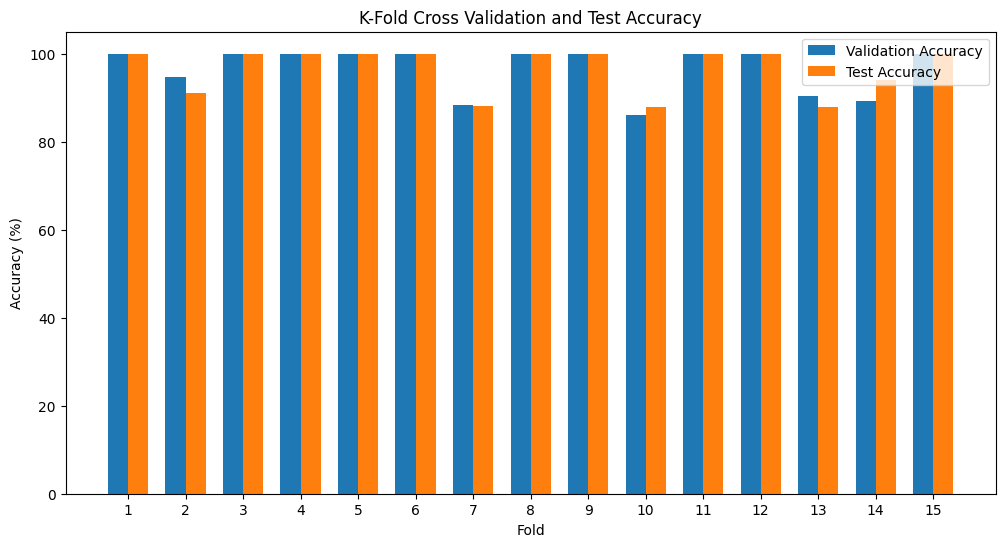

/var/folders/3j/2hpw7ptj4r565s37bww2_dhw0000gn/T/ipykernel_60745/2300687823.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([val_accuracies, test_accuracies], labels=['Validation Accuracy', 'Test Accuracy'])


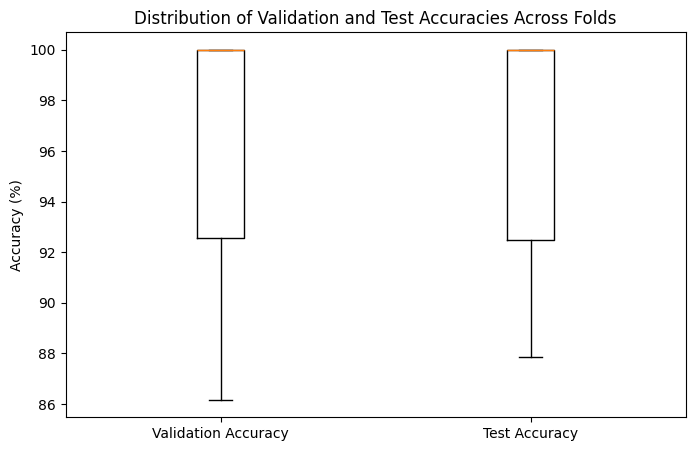

In [23]:
def plot_kfold_results(fold_results):
    # Unpack the fold results into separate lists
    val_accuracies = [result[1] for result in fold_results]
    test_accuracies = [result[3] for result in fold_results]
    
    # Number of folds
    n_folds = len(fold_results)
    x = np.arange(1, n_folds + 1)

    # Bar plot
    width = 0.35  # Width of the bars
    plt.figure(figsize=(12, 6))
    
    plt.bar(x - width/2, val_accuracies, width=width, label='Validation Accuracy')
    plt.bar(x + width/2, test_accuracies, width=width, label='Test Accuracy')
    
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.title('K-Fold Cross Validation and Test Accuracy')
    plt.xticks(x)
    plt.legend()
    plt.show()

def plot_loss_per_fold(train_losses_per_fold):
    plt.figure(figsize=(12, 6))
    
    for i, train_losses in enumerate(train_losses_per_fold, start=1):
        plt.plot(train_losses, label=f'Fold {i}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs for Each Fold')
    plt.legend(title='Folds')
    plt.show()

def plot_accuracy_distribution(fold_results):
    val_accuracies = [result[1] for result in fold_results]
    test_accuracies = [result[3] for result in fold_results]
    
    plt.figure(figsize=(8, 5))
    plt.boxplot([val_accuracies, test_accuracies], labels=['Validation Accuracy', 'Test Accuracy'])
    
    plt.ylabel('Accuracy (%)')
    plt.title('Distribution of Validation and Test Accuracies Across Folds')
    plt.show()




# K-fold cross-validation with an 8:1 split within training data for validation
def k_fold_cross_validation(model_class, combined_dataset, k=5, batch_size=32, num_epochs=150):
    kf = KFold(n_splits=k, shuffle=True)
    fold_results = []
    avg_val_losses, avg_val_accuracies, avg_test_losses, avg_test_accuracies = [], [], [], []

    for fold, (train_val_indices, test_indices) in enumerate(kf.split(combined_dataset)):
        print(f"\nStarting Fold {fold + 1}/{k}")

        train_val_subset = Subset(combined_dataset, train_val_indices)
        test_subset = Subset(combined_dataset, test_indices)

        # 8:1 split for train and validation
        train_size = int(0.9 * len(train_val_subset))
        val_size = len(train_val_subset) - train_size

        train_subset, val_subset = random_split(train_val_subset, [train_size, val_size])

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        train_size = len(train_loader.dataset) // 2
        remaining_size = len(train_loader.dataset) - train_size
        train_subset, _ = random_split(train_loader.dataset, [train_size, remaining_size])

        # Define a DataLoader for just the train subset
        train_subset_loader = DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True)

        # Train CNN_LSTM on the subset
        cnn_lstm_model = CNN_LSTM().to(device)
        trainCNN_LSTM(cnn_lstm_model, train_subset_loader, device, num_epochs=1)  # Use limited epochs

        # Freeze CNN_LSTM parameters after training on subset
        for param in cnn_lstm_model.parameters():
            param.requires_grad = False


        model = model_class(cnn_lstm_model, device).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_losses = train_full_model(model, train_loader, optimizer, criterion, num_epochs=num_epochs)

        val_loss, val_accuracy, val_batch_losses, val_batch_accuracies = evaluate_model(model, val_loader, criterion)
        test_loss, test_accuracy, test_batch_losses, test_batch_accuracies = evaluate_model(model, test_loader, criterion)

        avg_val_losses.append(val_loss)
        avg_val_accuracies.append(val_accuracy)
        avg_test_losses.append(test_loss)
        avg_test_accuracies.append(test_accuracy)

        print(f"Fold {fold + 1} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Fold {fold + 1} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        fold_results.append((val_loss, val_accuracy, test_loss, test_accuracy))

        # Clear memory
        del model
        torch.cuda.empty_cache()

    avg_val_loss = sum([result[0] for result in fold_results]) / k
    avg_val_accuracy = sum([result[1] for result in fold_results]) / k
    avg_test_loss = sum([result[2] for result in fold_results]) / k
    avg_test_accuracy = sum([result[3] for result in fold_results]) / k

    print(f"\nK-Fold Cross-Validation Results ({k} folds):")
    print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.2f}%")
    print(f"Average Test Loss: {avg_test_loss:.4f}, Average Test Accuracy: {avg_test_accuracy:.2f}%")

    return fold_results


# Perform k-fold cross-validation
fold_results = k_fold_cross_validation(FullCALMModel, combined_dataset, k=15, batch_size=32, num_epochs=150)

# Plot the results
plot_kfold_results(fold_results)
plot_accuracy_distribution(fold_results)